# Introduction: Deep Learning for Mesoscale Eddy Detection

In this chapter, we will cover how to leverage convolutional neural networks to detect mesoscale (100-300 km diameter) ocean eddies. Atmospheric wind together with solar heat flux at the sea surface drive the ocean circulation. The ocean's circulation is turbulent and full of small-scale vortices that have closed circulation contours. These vortices in the ocean are often refered to as ocean eddies - ocean analogues of atmospheric cyclones. Ocean eddies play an important role in the transport of heat, salt, carbon and other tracers that are important for marine biology and climate regulation. The interested reader new to oceanography is referred to __[Chelton](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007GL030812)__ for a review. 

Ocean eddies have particular thermalhaline structures that generate 'hills' and 'valleys' in the sea surface height (SSH). The SSH associated with these eddy features are on the order of tens of centimeters (above/below mean sea level), and can be detected using satellite altimetry. A satellite altimeter measures the distance between the satellite and the ocean surface by counting the round-trip time of radar pulses, which indirectly measures the SSH. A quick and accurate eddy detection can lead to better quantification of the influence of these eddies on the ocean's role in the Earth's climate system. 

In this chapter, we will leverage an existing open-source model and a gridded satellite altimetry product to illustrate how to use convolutional neural networks (CNN) to detect ocean eddies. CNNs mimic the brain's visual cortex, specifically the idea that groups of neurons only react to stimuli in a limited region of the visual field (i.e., they have a localized _receptive field_) and the hierarchical structure between higher-level and lower-level visual neurons. In fact, CNNs such as Yann LeCun's LeNet-5 architecture (LeCun et al., 1998) have been widely used since the 1990's for handwritten digit recognition and gained renewed attention when AlexNet (Krizhevsky et al., 2012) won the ILSVRC ImageNet challenge in 2012. We implement a version of __[EddyNet](https://github.com/redouanelg/EddyNet)__, a CNN for pixel-wise classification (i.e., semantic segmentation) of ocean eddies (Lguensat et al., 2018). Several iterations/variants of the EddyNet architecture have been described in the literature, including work by other researchers (e.g, Santana et al., 2020). Here, we focus on the baseline/"vanilla" version of EddyNet, as the emphasis is on illustrating an end-to-end machine learning workflow as opposed to model architecture development and fine-tuning.

# Chapter Overview

This chapter is organized as follows. We first discuss the eddy detection task and existing literature. We then discuss the data preparation process and provide details about the source dataset used throughout this chapter, the algorithm(s) used to obtain ground truth eddy masks from this dataset, and the utilities written to transform the data into a "machine learning-ready" dataset. Wherever possible, we discuss alternative data sources and algorithms that can be used in place of the ones used in this chapter. Next, we pose the eddy detection problem as a machine learning task (semantic segmentation, specifically) and describe a custom deep learning model by Lguensat et al. to solve this task. We provide an illustrative machine learning workflow and discuss relevant machine learning concepts such as training and testing sets, overfitting, transfer learning, and various metrics to evaluate model performance. Finally, we provide as homework and/or personal research assignments the future work identified in Lguensat et al. and __[Sun et al.](https://www.sciencedirect.com/science/article/pii/S0098300422000036)__. 

In terms of formatting, this chapter is split into two Jupyter notebooks: this first notebook, titled "Introduction", walks through the generation of a training and testing set with ground truth eddies. The second notebook, titled "Train Eddy Segmentation", loads the dataset and walks through the training workflow in PyTorch.


# Data Preparation

## AVISO-SSH data product
This chapter aims to detect eddies from sea level anomaly (SLA) using deep learning. Following Lguensat et al., we use the AVISO-SSH sea level product provided by the Copernicus Climate Change Service (C3S). This product provides daily global estimates of sea level anomaly at 0.25$^\circ$ resolution based on satellite altimetry measurements from 1993 to present, and can be downloaded __[here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=form)__. 

Eddy detection, when posed as a semantic segmentation task, is a _supervised learning_ problem. 
Given a dataset $\mathscr{D}$ that consists of a set of **examples** $x\in\mathscr{X}$ and corresponding **targets** or **labels** $y\in\mathscr{Y}$, supervised learning aims to obtain a model $f$ parameterized by $\theta$ that generates a prediction $\hat{y}$, i.e., $\hat{y} = f_{\theta}(x)$. 
For the eddy detection task, $\mathscr{X}$ is taken to be sea level anomaly (SLA) or absolute dynamic topography (ADT) obtained from the AVISO-SSH product, whereas the ground truth labels $\mathscr{Y}$ are pixel-level classifications of whether each pixel is a cyclonic eddy, anticyclonic eddy or not an eddy. We obtain $\mathscr{Y}$ using the __[_py-eddy-tracker_ algorithm](https://github.com/AntSimi/py-eddy-tracker)__ (Mason et al.), which is a geometric approach that takes SLA maps as input and outputs eddy properties. 

While the use of an automated algorithm as ground truth for another automated algorithm may seem circular at first glance, an ongoing area of research is to investigate whether machine learning models can be resolution and scale invariant. That is, we want to develop machine learning approaches that can be applied to identify not only mesoscale eddies, but also smaller (e.g., submesoscale) scale eddies as well. Conventional heuristic and physics-based models may not be directly applicable to submesoscale eddy identification without further refinement. Although the AVISO-SSH dataset's 0.25$^\circ$ resolution cannot capture submesoscale eddies, this task will become increasingly important with the launch of NASA's Surface Water and Ocean Topography (SWOT) mission. 

## Training and testing sets
One of the main challenges in machine learning is **overfitting**. Overfitting means that a model performs well on the training data, but exhibits significant performance degradation when it comes time to use the model on real or *test* data. In lieu of this challenge, the common approach when assembling a dataset is to split the examples into *training*, *validation*, and *test* sets. 

- The **train set** is the set of examples that we can use to update the model's parameters (e.g., $\theta$ in a linear regression model, $f_\theta(x) = \theta_0 + \theta_1 x$)
- The **validation set** set is the set of examples that we use as the "unseen" dataset during model development. In other words, we evaluate the model's (potentially several of them) performance on the validation set, and choose the combination of model and hyperparameters that perform the best on the validation set. <font color='red'>**Quiz**: what happens if you perform model selection and hyperparameter tuning on the training set? Which model would you end up choosing, and how would that model perform on "real" data?</font>
- When aiming to report an *unbiased* result, we run a final evaluation with our selected algorithm (model + hyperparameters) on the held-out **test set**. 

<div class="alert alert-block alert-danger">
⚠ The test set <b>should not</b> be used in any decision-making or algorithm development processes, and should only be used when reporting final results.
</div>



For the eddy detection task, we use SSH maps from 1998-2018 at a 10 day interval to train the model. Whereas Lguensat et al. use daily SSH maps, we use observations from every tenth day to account for the characteristic evolution time scale of mesoscale eddies and prevent the machine learning model from overfitting to particularly slow-moving eddies. We use SSH maps and the associated py-eddy-tracker outputs from 2019 as a test set to evaluate the machine learning model's performance on unseen data.

We download the SSH maps from C3S into the following directory structure:
```
/home/username/ML_eddies
│
└───cds_ssh_1998-2018_10day_interval  <- (this is the training set)
│       dt_global_twosat_phy_l4_19980101_vDT2021.nc
│       dt_global_twosat_phy_l4_19980110_vDT2021.nc
│       dt_global_twosat_phy_l4_19980120_vDT2021.nc
│                           ⋮
│       dt_global_twosat_phy_l4_20181230_vDT2021.nc
│   
└───cds_ssh_2019_10day_interval/    <- (this is the test set)
        dt_global_twosat_phy_l4_20190101_vDT2021.nc
        dt_global_twosat_phy_l4_20190110_vDT2021.nc
        dt_global_twosat_phy_l4_20190120_vDT2021.nc
                            ⋮
        dt_global_twosat_phy_l4_20191230_vDT2021.nc
```

For ease of use, these files can be downloaded __[here](https://drive.google.com/drive/folders/1A3XZDOn7sY4x1O1DdUReJRRXVp0a4u4S?usp=sharing)__


We will use py-eddy-tracker to generate segmentation masks for the data. First, we will provide an example with one data file that demonstrates how to use py-eddy-tracker, and then we will use the developed functions to process all of our data in parallel. 

In [1]:
import os
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset

We define some helper functions to visualize the data. Here, we leverage py-eddy-tracker's `GridDataset` capabilities but include additional plot elements using Python's `matplotlib` library. The reader is referred to the py-eddy-tracker documentation for additional information about its usage.

In [2]:
def start_axes(title):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
    ax.set_aspect("equal")
    ax.set_title(title, weight="bold")
    return ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))


def plot_variable(grid_object, var_name, ax_title, **kwargs):
    ax = start_axes(ax_title)
    m = grid_object.display(ax, var_name, **kwargs)
    update_axes(ax, m)
    ax.set_xlim(grid_object.x_c.min(), grid_object.x_c.max())
    ax.set_ylim(grid_object.y_c.min(), grid_object.y_c.max())
    return ax, m

# SSH map preprocessing

The SSH field contains a wide range of features, ranging from small to large-scale ones. Eddies are identified as features with diameters of 100-300 km, so the first step is to remove larger scale variability using a high-pass filter. Large-scale variability is computed by smoothing the Absolute Dynamic Topography (ADT) field with a first order Lanczos filter with a half-power cutoff wavelength of 700 km. The result is subtracted from the original ADT map to produce a high-pass filtered grid which contains only mesoscale variability. We illustrate the qualitative effect of this filter using an ADT map from the first day of our test set, January 1, 2019.

In [3]:
data_root = os.path.join(os.path.expanduser("~"), "ML_eddies")
train_folder = os.path.join(data_root, "cds_ssh_1998-2018_10day_interval")
test_folder = os.path.join(data_root, "cds_ssh_2019_10day_interval")

example_file = os.path.join(test_folder, "dt_global_twosat_phy_l4_20190101_vDT2021.nc")
date = datetime(2019, 1, 1)
g = RegularGridDataset(example_file, "longitude", "latitude")

We assume pixel position of grid is centered for /home/edwin/ML_eddies/cds_ssh_2019_10day_interval/dt_global_twosat_phy_l4_20190101_vDT2021.nc


No filtering above 85.000000 degrees of latitude


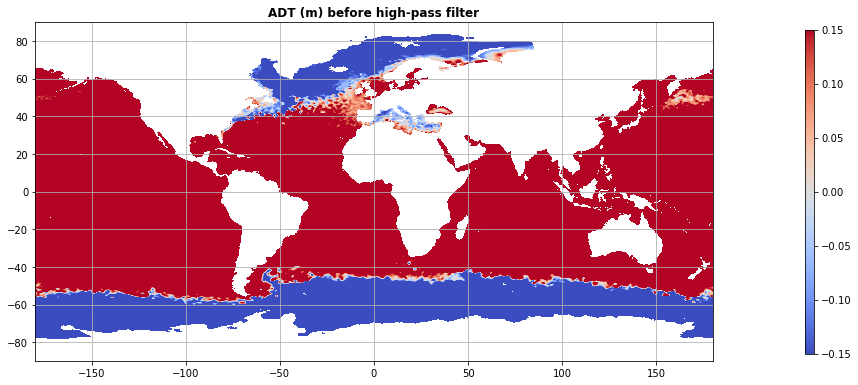

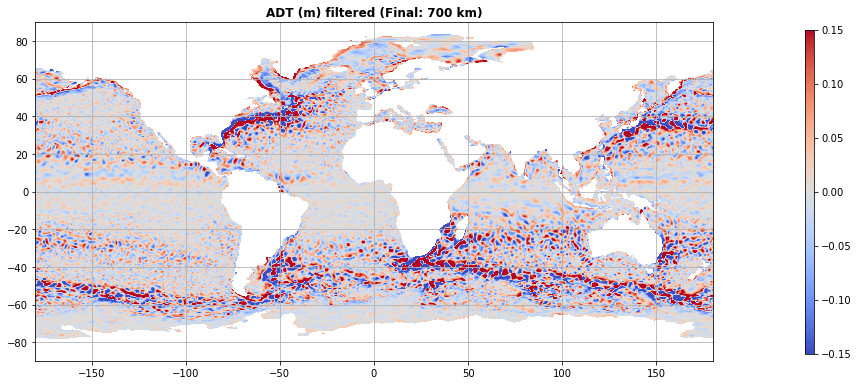

In [4]:
from copy import deepcopy

ax, m = plot_variable(
    g,
    "adt",
    f"ADT (m) before high-pass filter",
    vmin=-0.15,
    vmax=0.15,
)
wavelength_km = 700
g_filtered = deepcopy(g)
g_filtered.bessel_high_filter("adt", wavelength_km)
ax, m = plot_variable(
    g_filtered,
    "adt",
    f"ADT (m) filtered (Final: {wavelength_km} km)",
    vmin=-0.15,
    vmax=0.15,
)

## Generate ground truth eddy masks using the py-eddy-tracker algorithm

In the below functions, we have combined the filtering and identification into one function that takes in a gridded SSH file and generates the segmentation mask in the form of a `numpy` array --- `generate_segmentation_mask_from_file`. Each pixel in the segmentation mask is assigned a class: {0: Not eddy; 1: anticyclonic eddy; 2: cyclonic eddy}.

Note that the x variable, longitude, in the py-eddy-tracker `GridDataset` object, which contains the Aviso ADT measurements, span -180$^\circ$ to 180$^\circ$. However, the py-eddy-tracker `EddiesObservations` objects go from 0$^\circ$ to 360$^\circ$. Because of this difference, we add an `x_offset` and `y_offset` parameter to the `generate_segmentation_mask` function. If your ADT or SLA data goes from $0^\circ$ to $360^\circ$, you can simply pass in a 0 offset. 

In [5]:
from matplotlib.path import Path
from py_eddy_tracker.poly import create_vertice


def generate_segmentation_mask_from_file(
    gridded_ssh_file,
    date,
    ssh_var="adt",
    u_var="ugosa",
    v_var="vgosa",
    high_pass_wavelength_km=700,
    x_offset=0,
    y_offset=0,
):
    g, g_filtered, anticyclonic, cyclonic = identify_eddies(
        gridded_ssh_file, date, ssh_var, u_var, v_var, high_pass_wavelength_km
    )
    mask = generate_segmentation_mask(
        g_filtered, anticyclonic, cyclonic, x_offset, y_offset
    )
    var = g.grid(ssh_var)
    var_filtered = g_filtered.grid(ssh_var)
    return var, var_filtered, mask


def identify_eddies(
    gridded_ssh_file,
    date,
    ssh_var="adt",
    u_var="ugosa",
    v_var="vgosa",
    high_pass_wavelength_km=700,
):
    g = RegularGridDataset(gridded_ssh_file, "longitude", "latitude")
    g_filtered = deepcopy(g)  # make a copy so we don't alter the original
    g_filtered.bessel_high_filter(ssh_var, high_pass_wavelength_km)
    anticyclonic, cyclonic = g_filtered.eddy_identification(ssh_var, u_var, v_var, date)
    return g, g_filtered, anticyclonic, cyclonic


def generate_segmentation_mask(
    grid_dataset, anticyclonic, cyclonic, x_offset, y_offset, plot=False
):
    """
    Creates a numpy array to store the segmentation mask for the grid_dataset.
    The mask contains classes 0: no eddy, 1: anticyclonic eddy, 2: cyclonic eddy.
    """
    assert (
        cyclonic.sign_legend == "Cyclonic"
        and anticyclonic.sign_legend == "Anticyclonic"
    ), "Check whether the correct order for (anti)cyclonic observations were provided."
    mask = np.zeros(grid_dataset.grid("adt").shape, dtype=np.uint8)
    # cyclonic should have the same: x_name = 'contour_lon_e', y_name = 'contour_lat_e'
    x_name, y_name = anticyclonic.intern(False)
    for eddy in anticyclonic:
        x_list = (eddy[x_name] - x_offset) % 360 + x_offset
        vertices = create_vertice(x_list, eddy[y_name] + y_offset)
        i, j = Path(vertices).pixels_in(grid_dataset)
        mask[i, j] = 1

    for eddy in cyclonic:
        x_list = (eddy[x_name] - x_offset) % 360 + x_offset
        y_list = eddy[y_name] + y_offset
        i, j = Path(create_vertice(x_list, y_list)).pixels_in(grid_dataset)
        mask[i, j] = 2

    if plot:
        ax, m = plot_variable(grid_dataset, mask, "Segmentation Mask", cmap="viridis")
    return mask

Here, we run the py-eddy-tracker algorithm on the first image on our test set. The first figure shows the contours created by py-eddy-tracker, and the second image shows the segmentation mask, where pixels enclosed by eddy contours identified by the py-eddy-tracker algorithm are "shaded". Each pixel in eddy segmentation masks can belong to one of three classes:

| Index | Label |
| --- | --- |
| 0 | Not eddy |
| 1 | Anticyclonic eddy |
| 2 | Cyclonic eddy |

This looks very similar to the pioneering work done by Chelton et al. (2011). While there is no unqiue way of identifying an eddy from altimetry, closed SSH contours are probably the universally agreed "safe" definition. 

We assume pixel position of grid is centered for /home/edwin/ML_eddies/cds_ssh_2019_10day_interval/dt_global_twosat_phy_l4_20190101_vDT2021.nc
No filtering above 85.000000 degrees of latitude


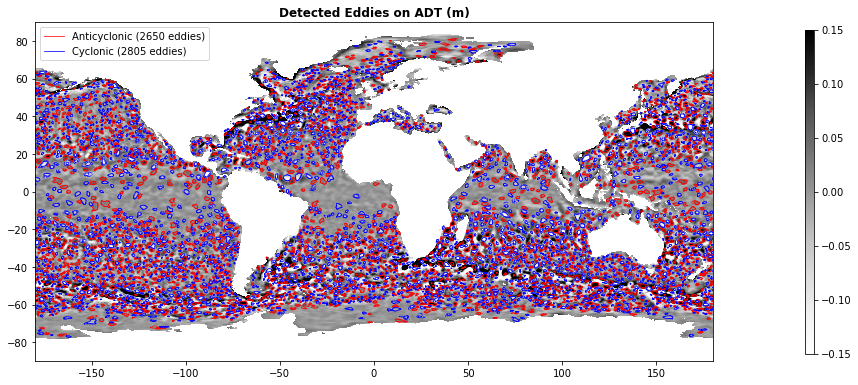

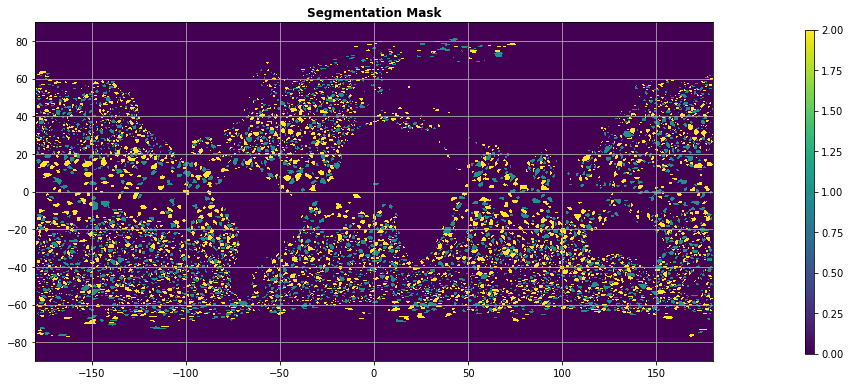

In [6]:
g, g_filtered, anticyclonic, cyclonic = identify_eddies(example_file, date)
ax, m = plot_variable(
    g_filtered, "adt", "Detected Eddies on ADT (m)", vmin=-0.15, vmax=0.15, cmap="Greys"
)
anticyclonic.display(
    ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-180
)
cyclonic.display(
    ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-180
)
ax.legend()
update_axes(ax)

# Plot segmentation mask
mask = generate_segmentation_mask(
    g_filtered, anticyclonic, cyclonic, -180, 0, plot=True
)

# Use `multiprocessing` to generate segmentation masks in parallel

The py-eddy-tracker code operates on a global scale, so global SSH maps are passed into the `identify_eddies` function. However, Mason et al. recognize that the code "slows down significantly" when used under global scales. Indeed, it takes around 30 seconds to generate a global segmentation mask from a single global SSH map.

<div class="alert alert-block alert-success">
<b>Cheap inference:</b> One advantage of an accurate ML-based eddy detection algorithm is that using the trained model to detect eddies on new SSH snapshots (i.e., running <i>inference</i>) is computationally inexpensive, especially when the process is parallelized using a GPU. Even a mobile, laptop-based NVIDIA GPU can provide significant speedup over a serial CPU implementation. Libraries such as PyTorch and TensorFlow abstract the complexities of utilizing GPU hardware to enable seamless access to this form of parallelism.
</div>

Here, we will use Python's built-in `multiprocessing` library to run the `generate_segmentation_mask_from_file` function in parallel. This will allow us to generate ground truth eddy segmentation masks at global scale for multiple days at once.

In [7]:
import multiprocessing


def generate_masks_in_parallel(
    files,
    dates,
    ssh_var="adt",
    u_var="ugosa",
    v_var="vgosa",
    high_pass_wavelength_km=700,
    x_offset=-180,
    y_offset=0,
    num_processes=8,
    plot=False,
    save=True,
):
    args = [
        (file, date, ssh_var, u_var, v_var, high_pass_wavelength_km, x_offset, y_offset)
        for file, date in zip(files, dates)
    ]
    pool = multiprocessing.Pool(processes=num_processes)
    results = pool.starmap(generate_segmentation_mask_from_file, args)

    vars_ = []
    vars_filtered = []
    masks = []
    for result in results:
        vars_.append(result[0])
        vars_filtered.append(result[1])
        masks.append(result[2])

    # concatenate list into single numpy array and return
    masks = np.stack(masks, axis=0)
    vars_ = np.stack(vars_, axis=0).astype(np.float32)
    vars_filtered = np.stack(vars_filtered, axis=0).astype(np.float32)

    if save:
        # find common folder across all files
        common_folder = os.path.commonpath(files)
        years = sorted(set([date.year for date in dates]))
        year_str = f"{years[0]}" if len(years) == 1 else f"{min(years)}-{max(years)}"
        save_path = os.path.join(
            common_folder, f"global_pet_masks_with_{ssh_var}_{year_str}.npz"
        )
        np.savez_compressed(
            save_path,
            masks=masks,
            dates=dates,
            var=vars_,
            var_filtered=vars_filtered,
        )
        print(f"Saved masks to {save_path}")

    return vars_, vars_filtered, masks


from itertools import product


def get_dates_and_files(years, months, days, folder, file_pattern):
    """
    Given a filename pattern and a list of years months and days,
    fill in the filename pattern with the date and return
    a list of filenames and a list of associated `datetime` objects.

    Args:
        years (list): list of years, e.g., [1993, 1994, 1995, 1996]
        months (list): list of months, e.g., [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        days (list): list of days, e.g., [1, 10, 20, 30] for every 10th day
        folder (str): folder where the files are located
        file_pattern (str): filename pattern, e.g.,
            "dt_global_twosat_phy_l4_{year:04d}{month:02d}{day:02d}_vDT2021.nc"

    Returns:
        files (list): full/absolute path to each netCDF file in the list of dates
        dates (list): list of `datetime` objects formed from the combination of years, months and days
    """
    dates, files = [], []
    for y, m, d in product(years, months, days):  # cartesian product
        try:
            date = datetime(y, m, d)
            file = os.path.join(folder, file_pattern.format(year=y, month=m, day=d))
            dates.append(date)
            files.append(file)
        # catch ValueError thrown by datetime if date is not valid
        except ValueError:
            pass
    years = f"{years[0]}" if len(years) == 1 else f"{min(years)}-{max(years)}"
    print(f"Found {len(dates)} files for {years}.")
    return dates, files

In [8]:
import logging
logging.getLogger("pet").setLevel(logging.ERROR)

# enter the AVISO filename pattern
# year, month, and day in file_pattern will be filled in get_dates_and_files:
file_pattern = "dt_global_twosat_phy_l4_{year:04d}{month:02d}{day:02d}_vDT2021.nc"

# training set: 1998 - 2018
train_dates, train_files = get_dates_and_files(
    range(1998, 2019), range(1, 13), [1, 10, 20, 30], train_folder, file_pattern
)
train_adt, train_adt_filtered, train_masks = generate_masks_in_parallel(
    train_files, train_dates
)


# test set: 2019
test_dates, test_files = get_dates_and_files(
    [2019], range(1, 13), [1, 10, 20, 30], test_folder, file_pattern
)
test_adt, test_adt_filtered, test_masks = generate_masks_in_parallel(
    test_files, test_dates
)

Found 987 files for 1998-2018.
Saved masks to /home/edwin/ML_eddies/cds_ssh_1998-2018_10day_interval/global_pet_masks_with_adt_1998-2018.npz
Found 47 files for 2019.
Saved masks to /home/edwin/ML_eddies/cds_ssh_2019_10day_interval/global_pet_masks_with_adt_2019.npz


# Take a subset of the masks and SSH map, and save to a compressed `numpy` (.npz) file

The `subset_arrays` function below takes in the segmentation mask, raw and filtered SSH (`var`, `var_filtered`), the desired lat-lon range, and outputs the mask and SSH map for that region.

In [9]:
def subset_arrays(
    masks,
    var,
    var_filtered,
    dates,
    lon_range,
    lat_range,
    resolution_deg,
    plot=False,
    ssh_var="adt",
    save_folder=None,
):
    """
    Subset the arrays to the given lon_range and lat_range.

    Args:
        masks (np.ndarray): Global eddy segmentation masks.
            Can be masks from multiple dates concatenated into one array
        var (np.ndarray): Global SSH value
        var_filtered (np.ndarray): Global SSH value after high-pass filter
        dates (list): List of `datetime` objects
        lon_range (tuple): Longitude range to subset to (lon_start, lon_end)
        lat_range (tuple): Latitude range to subset to (lat_start, lat_end)
        resolution_deg (float): Resolution of the SSH map in degrees
        plot (bool): Whether to plot a sample of the subsetted arrays
        ssh_var (str): SSH variable name. Defaults to "adt". Only used if save_folder is not None.
        save_folder (str): Folder to save the subsetted arrays to. Defaults to None.
            If None, the arrays are not saved.

    Returns:
        mask_subset (np.ndarray): Subsetted masks
        var_subset (np.ndarray): Subsetted var
        var_filtered_subset (np.ndarray): Subsetted var_filtered
        lon_subset (np.ndarray): Subsetted lon
        lat_subset (np.ndarray): Subsetted lat
    """
    lon_bounds = np.arange(-180, 180 + resolution_deg, resolution_deg) 
    lat_bounds = np.arange(-90, 90 + resolution_deg, resolution_deg)

    # convert lon_range and lat_range to indices in the numpy arrays
    lon_start, lon_end = lon_range
    lat_start, lat_end = lat_range
    lon_idx = lambda lon: np.argmin(np.abs(lon_bounds - lon))
    lat_idx = lambda lat: np.argmin(np.abs(lat_bounds - lat))
    lon_start_idx, lon_end_idx = lon_idx(lon_start), lon_idx(lon_end)
    lat_start_idx, lat_end_idx = lat_idx(lat_start), lat_idx(lat_end)

    mask_subset = masks[:, lon_start_idx:lon_end_idx, lat_start_idx:lat_end_idx]
    var_subset = var[:, lon_start_idx:lon_end_idx, lat_start_idx:lat_end_idx]
    var_filtered_subset = var_filtered[
        :, lon_start_idx:lon_end_idx, lat_start_idx:lat_end_idx
    ]
    lon_subset = lon_bounds[lon_start_idx : lon_end_idx + 1]
    lat_subset = lat_bounds[lat_start_idx : lat_end_idx + 1]
    if plot:
        fig, ax = plt.subplots()
        if mask_subset.ndim == 3:
            m = mask_subset[0]
            v = var_subset[0]
        elif mask_subset.ndim == 2:
            m = mask_subset
            v = var_subset
        ax.pcolormesh(lon_subset, lat_subset, m.T, vmin=0, vmax=2, cmap="viridis")
        ax.set_xlim(lon_start, lon_end)
        ax.set_ylim(lat_start, lat_end)
        ax.set_aspect(abs((lon_end - lon_start) / (lat_start - lat_end)) * 1.0)

    if save_folder is not None:
        all_years = sorted(set([d.year for d in dates]))
        year_str = (
            f"{all_years[0]}"
            if len(all_years) == 1
            else f"{min(all_years)}-{max(all_years)}"
        )
        lat_str = lat_range_to_str(lat_range)
        lon_str = lon_range_to_str(lon_range)
        save_path = os.path.join(
            save_folder,
            f"subset_pet_masks_with_{ssh_var}_{year_str}_lat{lat_str}_lon{lon_str}.npz",
        )
        np.savez_compressed(
            save_path,
            masks=mask_subset,
            dates=dates,
            var=var_subset,
            var_filtered=var_filtered_subset,
            lon_subset=lon_subset,
            lat_subset=lat_subset,
        )
        print(f"Saved mask subset to {save_path}")
    return mask_subset, var_subset, var_filtered_subset, lon_subset, lat_subset


def lon_range_to_str(lon_range):
    lon_start, lon_end = lon_range
    lon_start = f"{lon_start}E" if lon_start >= 0 else f"{abs(lon_start)}W"
    lon_end = f"{lon_end}E" if lon_end >= 0 else f"{abs(lon_end)}W"
    return f"{lon_start}-{lon_end}"


def lat_range_to_str(lat_range):
    lat_start, lat_end = lat_range
    lat_start = f"{lat_start}N" if lat_start >= 0 else f"{abs(lat_start)}S"
    lat_end = f"{lat_end}N" if lat_end >= 0 else f"{abs(lat_end)}S"
    return f"{lat_start}-{lat_end}"

We focus on a $32^{\circ}$ x $32^{\circ}$ region in the Northern Pacific Ocean.
Since each pixel is 0.25$^{\circ}$, this region corresponds to a patch of 128x128 pixels.  
There are three motivators for subsetting this region:
1. Test region for SWOT - the Northern Pacific Ocean will be the target of SWOT's fast-revisit phase.
2. Map projections are more uniform in these latitude, and thus more representative of the 0.25$^{\circ}$ resolution.
3. 128x128 is a fairly common size for CNN inputs

Saved mask subset to /home/edwin/ML_eddies/cds_ssh_1998-2018_10day_interval/subset_pet_masks_with_adt_1998-2018_lat14N-46N_lon166W-134W.npz
Saved mask subset to /home/edwin/ML_eddies/cds_ssh_2019_10day_interval/subset_pet_masks_with_adt_2019_lat14N-46N_lon166W-134W.npz


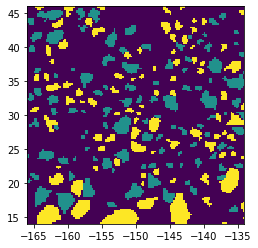

In [10]:
# northern pacific (32x32 degree -> 128x128 pixels)
lon_range = (-166, -134)
lat_range = (14, 46)

train_subset = subset_arrays(
    train_masks,
    train_adt,
    train_adt_filtered,
    train_dates,
    lon_range,
    lat_range,
    plot=False,
    resolution_deg=0.25,
    save_folder=train_folder,
)

test_subset = subset_arrays(
    test_masks,
    test_adt,
    test_adt_filtered,
    test_dates,
    lon_range,
    lat_range,
    plot=True,
    resolution_deg=0.25,
    save_folder=test_folder,
)
